# Project 4 - Movie Recommendation System
In this project I will be building a movie recommendation system using a dataset from MovieLens. The system that I will be building is a collaborative filtering system. I will iteratively go through different methods and after comparing their metrics and scores, I will choose the final model. The final model will give out the top 5 recommendations for a user and will also be able to intake a certain genre for recommendation within it. Therefore the final recommender will be a hybrid system using both content based and user based methods.

## The Data
The data that I will be using is the MovieLens dataset from the GroupLens research lab at the University of Minnesota. I had the choice of using the full dataset or a small subset. In order to make computation time managable, I chose to go with the smaller dataset.

The first thing I will do is import some of the libraries that I will be using. Then I will read the data into a pandas dataframe to analyze.

In [1]:
# Import and install the necessary libraries
import pandas as pd
!pip install surprise
from surprise.prediction_algorithms import knns
from surprise.similarities import cosine, msd, pearson
from surprise import accuracy
from surprise import Reader, Dataset
from matplotlib import pyplot as plt
import numpy as np

     |████████████████████████████████| 11.8MB 229kB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1617605 sha256=1778350f3bcb5d32ccbcbaec59477c81405bcacbce4415997f0bb3e91bc6dbe0
  Stored in directory: /root/.cache/pip/wheels/78/9c/3d/41b419c9d2aff5b6e2b4c0fc8d25c538202834058f9ed110d0
Successfully built scikit-surprise


In [2]:
# First I will load the data into a dataframe to analyze it.
df = pd.read_csv("ratings.csv")
display(df.head())
print('Length of the dataset')
print(len(df))
print('Number of users in the dataset')
print(df['userId'].nunique())
print('Number of movies in the dataset')
print(df['movieId'].nunique())

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


Length of the dataset
100836
Number of users in the dataset
610
Number of movies in the dataset
9724


Our dataset have 100836 ratings, 610 unique users and 9724 unique movies in it.

The first thing that I will do with the dataset is remove the timestamp column which is unnecessary for this project. 

In [3]:
#Drop the 'timestamp' column and then check the dataframe
df.drop('timestamp', axis=1, inplace=True)
df.head()

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


In [4]:
#Read in the dataset with the movie names and genres
names_df = pd.read_csv('movies.csv')
names_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


# Unpersonalized Recommendations
First I will take a look at the average highest rated movies. This is considered to be an unpersonalized recommendations and is not a bad system to include in a service. It will show the users the most popular movies, which they might be interested in.

In our dataset there are a few movies with just a single rating given to it, which could be considered as outliers. In order to get rid of these outliers, I will filter out movies with 20 ratings or less.

In [5]:
#Filter out the movies with 20 ratings or less
df2 = df.groupby('movieId').filter(lambda x : len(x)>20)
df2.value_counts('movieId')

movieId
356     329
318     317
296     307
593     279
2571    278
       ... 
383      21
262      21
2067     21
2013     21
830      21
Length: 1235, dtype: int64

In [6]:
#Group the dataframe by movieId and get the average rating
df_movie_grp = df2.groupby('movieId')
movie_ratings = df_movie_grp['rating'].mean()
movie_ratings = movie_ratings.reset_index()

#Join the prepared rating dataframe with the dataframe containing movie titles
movie_ratings = pd.concat([movie_ratings.set_index('movieId'),names_df.set_index('movieId')], axis=1, join='inner')
movie_ratings.sort_values(by='rating', ascending=False, inplace=True)

In [7]:
top_30_movies = movie_ratings.head(30)
#Show the Top 30 Highest Rated Movies
top_30_movies

,rating,title,genres
movieId,,,
318,4.429022,"Shawshank Redemption, The (1994)",Crime|Drama
922,4.333333,Sunset Blvd. (a.k.a. Sunset Boulevard) (1950),Drama|Film-Noir|Romance
898,4.310345,"Philadelphia Story, The (1940)",Comedy|Drama|Romance
475,4.300000,In the Name of the Father (1993),Drama
1204,4.300000,Lawrence of Arabia (1962),Adventure|Drama|War
246,4.293103,Hoop Dreams (1994),Documentary
858,4.289062,"Godfather, The (1972)",Crime|Drama
1235,4.288462,Harold and Maude (1971),Comedy|Drama|Romance
168252,4.280000,Logan (2017),Action|Sci-Fi


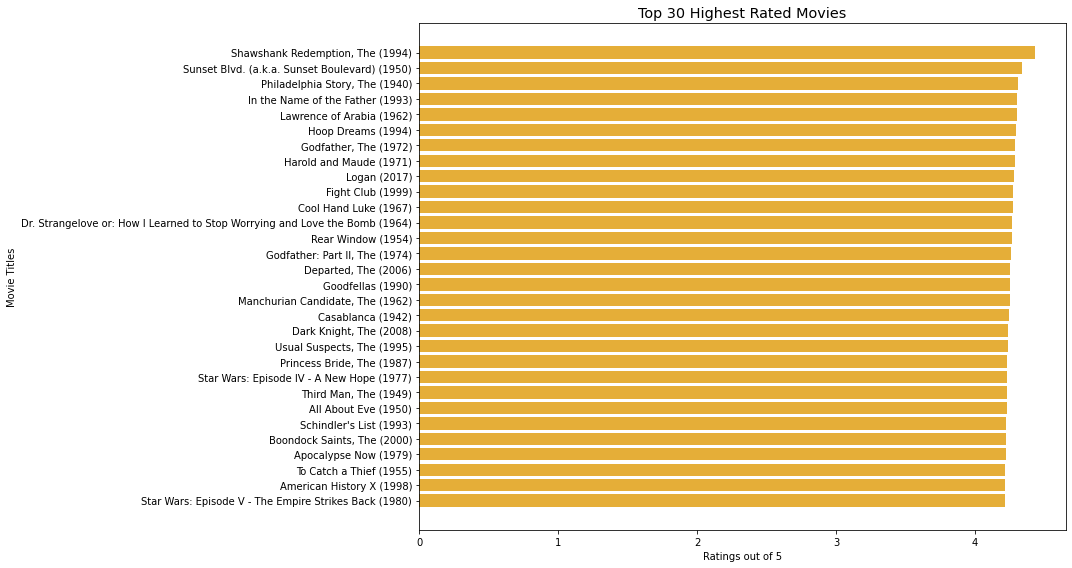

In [8]:
#Plot the titles and ratings to get a better idea

fig, ax = plt.subplots(figsize=(15,8))
plt.style.use("ggplot")

#Create indexes for the titles
x_indexes = np.arange(len(top_30_movies['rating']))

ax.barh(x_indexes, top_30_movies.sort_values(by='rating', ascending=True)['rating'], color="#e5ae38")

#Set the titles as y-tick labels
plt.yticks(ticks =x_indexes, labels=top_30_movies.sort_values(by='rating', ascending=True)['title'] )

#Set titles and labels
ax.set_title("Top 30 Highest Rated Movies")
ax.set_xlabel("Ratings out of 5")
ax.set_ylabel("Movie Titles")

plt.tight_layout()
plt.show()

The bar plot above shows the top 30 highest rated movies in our dataset with at least 21 ratings given. We can see that it is filled with critically acclaimed films that a lot of people love. A user might be interested in taking a look at this list to see if they want to watch any of these movies.

Although the list above shows the users the popular movies, it fails to suggest the niche movies that the user might be interested in. In order to achieve this, we will have to build a personalized recommender.

# Memory-Based / Neighborhood-Based Collaborative Filtering
The first personalized recommender systems that I will build are memory-based collaborative filtering systems. I will be using several algorithms and see which have the best metrics. I will also be using user-based collaborative filtering instead of item-based because the number of items will make the computation time difficult to handle.

I will be using the surprise library from scikit to build my recommendation system. So first I will read the data into a suprise dataframe. I will be using a 5 fold cross-validation to test the systems.

The Dataset.load_from_df method takes in a pandas dataframe with three columns. The columns have to be in the order of user_id, item_id, and finally the ratings. Our dataframe is already in this format so we can just use it.

In [9]:
#Read the data into a format for surprise
reader = Reader()
data = Dataset.load_from_df(df,reader)

dataset = data.build_full_trainset()
print('Number of users: ', dataset.n_users, '\n')
print('Number of items: ', dataset.n_items)

Number of users:  610 

Number of items:  9724


In [10]:
# importing relevant libraries
from surprise.model_selection import cross_validate
from surprise.prediction_algorithms import SVD
from surprise.prediction_algorithms import KNNWithMeans, KNNBasic, KNNBaseline
from surprise.model_selection import GridSearchCV
from surprise.model_selection import train_test_split


#Create a dataframe to compare and later plot
algor_metrics = pd.DataFrame(columns = ['algorithm', 'test_rmse', 'test_mae'])

First I will build a model with the basic K-Nearest Neighbour algorithm, using Pearson Correlation and then Cosine as similarity metrics.

I will also append the results to a dataframe so the I can compare all the methods at the end.

In [11]:
#Choose the algorithms and sim options, then do a five fold cross validation
knn_basic_pearson = KNNBasic(sim_options={'name':'pearson', 'user_based':True})
cv_knn_basic_pearson = cross_validate(knn_basic_pearson, data, cv=5, n_jobs=-1)

for i in cv_knn_basic_pearson.items():
    print(i)
print('-----------------------')
print(np.mean(cv_knn_basic_pearson['test_rmse']))

#Append the metrics and algorithm name to the dataframe
algor_metrics = algor_metrics.append({'algorithm': 'knnbasic_p', 'test_rmse': (np.mean(cv_knn_basic_pearson['test_rmse'])), 'test_mae': (np.mean(cv_knn_basic_pearson['test_mae']))}, ignore_index=True)


('test_rmse', array([0.96447045, 0.96062552, 0.97820012, 0.97688551, 0.97421999]))
('test_mae', array([0.74600167, 0.7439193 , 0.75237196, 0.75512399, 0.75160451]))
('fit_time', (0.7219698429107666, 0.7857184410095215, 0.7285408973693848, 0.7600984573364258, 0.4287118911743164))
('test_time', (2.6613123416900635, 2.3757388591766357, 2.4259262084960938, 2.3446617126464844, 1.2728683948516846))
-----------------------
0.9708803191976687


In [12]:
#Choose the algorithms and sim options, then do a five fold cross validation
knn_basic_cosine = KNNBasic(sim_options={'name':'cosine', 'user_based':True})
cv_knn_basic_cosine = cross_validate(knn_basic_cosine, data, cv=5, n_jobs=-1)

for i in cv_knn_basic_cosine.items():
    print(i)
print('-----------------------')
print(np.mean(cv_knn_basic_cosine['test_rmse']))

#Append the metrics and algorithm name to the dataframe
algor_metrics = algor_metrics.append({'algorithm': 'knnbasic_c', 'test_rmse': (np.mean(cv_knn_basic_cosine['test_rmse'])), 'test_mae': (np.mean(cv_knn_basic_cosine['test_mae']))}, ignore_index=True)



('test_rmse', array([0.96851538, 0.97689067, 0.9684948 , 0.97838066, 0.97373681]))
('test_mae', array([0.74839124, 0.74986324, 0.74480487, 0.75006859, 0.75163252]))
('fit_time', (0.48327112197875977, 0.49780941009521484, 0.4724395275115967, 0.47667598724365234, 0.25129008293151855))
('test_time', (2.4114272594451904, 2.4188690185546875, 2.437478542327881, 2.425388813018799, 1.2648253440856934))
-----------------------
0.9732036640719469


The RMSE is quiet high for both methods above, so it seems the basic KNN model isn't that good for our dataset.

The next model that I will try is KNN with means. This is similar to the basic KNN model, except it takes into account the mean rating of each user.

In [13]:
#Choose the algorithms and sim options, then do a five fold cross validation
knn_with_means_pearson = KNNWithMeans(sim_options={'name':'pearson', 'user_based':True})
cv_knn_with_means_pearson = cross_validate(knn_with_means_pearson, data, cv=5, n_jobs=-1)

for i in cv_knn_with_means_pearson.items():
    print(i)
print('-----------------------')
print(np.mean(cv_knn_with_means_pearson['test_rmse']))

#Append the metrics and algorithm name to the dataframe
algor_metrics = algor_metrics.append({'algorithm': 'knn_means_p', 'test_rmse': (np.mean(cv_knn_with_means_pearson['test_rmse'])), 'test_mae': (np.mean(cv_knn_with_means_pearson['test_mae']))}, ignore_index=True)


('test_rmse', array([0.90386338, 0.8851316 , 0.90765166, 0.89673014, 0.89859869]))
('test_mae', array([0.68925429, 0.67672354, 0.69014381, 0.6839332 , 0.68237303]))
('fit_time', (0.7294847965240479, 0.8616361618041992, 0.8380703926086426, 0.9011361598968506, 0.6605279445648193))
('test_time', (2.818603038787842, 2.729881525039673, 2.7775652408599854, 2.6196038722991943, 1.3944220542907715))
-----------------------
0.898395091964723


In [14]:
#Choose the algorithms and sim options, then do a five fold cross validation
knn_with_means_cosine = KNNWithMeans(sim_options={'name':'cosine', 'user_based':True})
cv_knn_with_means_cosine = cross_validate(knn_with_means_cosine, data, cv=5, n_jobs=-1)

for i in cv_knn_with_means_cosine.items():
    print(i)
print('-----------------------')
print(np.mean(cv_knn_with_means_cosine['test_rmse']))

#Append the metrics and algorithm name to the dataframe
algor_metrics = algor_metrics.append({'algorithm': 'knn_means_c', 'test_rmse': (np.mean(cv_knn_with_means_cosine['test_rmse'])), 'test_mae': (np.mean(cv_knn_with_means_cosine['test_mae']))}, ignore_index=True)

('test_rmse', array([0.90117892, 0.89578138, 0.9046974 , 0.90914615, 0.895989  ]))
('test_mae', array([0.68828156, 0.68796662, 0.69260664, 0.69291424, 0.68660311]))
('fit_time', (0.4867889881134033, 0.5126039981842041, 0.5576791763305664, 0.5439906120300293, 0.3987922668457031))
('test_time', (2.650646924972534, 2.8040993213653564, 2.684476137161255, 2.6643171310424805, 1.4074921607971191))
-----------------------
0.9013585707601088


We see an improvement over the KNN basic for both Pearson and Cosine similarity metrics but the RMSE is still quite high.

Next, I will try KNN Baseline which adds a bias term in the cost function that is minimized.

In [15]:
#Choose the algorithms and sim options, then do a five fold cross validation
knn_baseline_pearson = KNNBaseline(sim_options={'name':'pearson', 'user_based':True})
cv_knn_baseline_pearson = cross_validate(knn_baseline_pearson, data, cv=5, n_jobs=-1)

for i in cv_knn_baseline_pearson.items():
    print(i)
print('-----------------------')
print(np.mean(cv_knn_baseline_pearson['test_rmse']))

#Append the metrics and algorithm name to the dataframe
algor_metrics = algor_metrics.append({'algorithm': 'knn_basel_p', 'test_rmse': (np.mean(cv_knn_baseline_pearson['test_rmse'])), 'test_mae': (np.mean(cv_knn_baseline_pearson['test_mae']))}, ignore_index=True)

('test_rmse', array([0.87832201, 0.88492098, 0.879791  , 0.8758887 , 0.87253901]))
('test_mae', array([0.66957644, 0.67380037, 0.67148614, 0.67188643, 0.66414576]))
('fit_time', (0.8272855281829834, 1.2423992156982422, 1.358529806137085, 1.3290226459503174, 0.8048150539398193))
('test_time', (3.869758367538452, 3.9837141036987305, 4.057138919830322, 3.548759937286377, 1.9739365577697754))
-----------------------
0.878292340738082


In [16]:
#Choose the algorithms and sim options, then do a five fold cross validation
knn_baseline_cosine= KNNBaseline(sim_options={'name':'cosine', 'user_based':True})
cv_knn_baseline_cosine= cross_validate(knn_baseline_cosine, data, cv=5, n_jobs=-1)

for i in cv_knn_baseline_cosine.items():
    print(i)
print('-----------------------')
print(np.mean(cv_knn_baseline_cosine['test_rmse']))

#Append the metrics and algorithm name to the dataframe
algor_metrics = algor_metrics.append({'algorithm': 'knn_basel_c', 'test_rmse': (np.mean(cv_knn_baseline_cosine['test_rmse'])), 'test_mae': (np.mean(cv_knn_baseline_cosine['test_mae']))}, ignore_index=True)

('test_rmse', array([0.88340066, 0.88226848, 0.87667592, 0.87340862, 0.8700487 ]))
('test_mae', array([0.6764394 , 0.67422627, 0.66896529, 0.66907473, 0.6679188 ]))
('fit_time', (0.5881540775299072, 1.0213212966918945, 0.7957248687744141, 1.0906944274902344, 0.6011011600494385))
('test_time', (3.678774118423462, 4.191096544265747, 4.199119806289673, 3.553966760635376, 2.05741810798645))
-----------------------
0.8771604755530482


Again we see an improvement over KNN with means for both similarity metrics. 

In [17]:
#Look at the dataframe containing the results
algor_metrics.sort_values(by='test_rmse', axis=0, inplace=True)
algor_metrics

,algorithm,test_rmse,test_mae
5,knn_basel_c,0.877160,0.671325
4,knn_basel_p,0.878292,0.670179
2,knn_means_p,0.898395,0.684486
3,knn_means_c,0.901359,0.689674
0,knnbasic_p,0.970880,0.749804
1,knnbasic_c,0.973204,0.748952


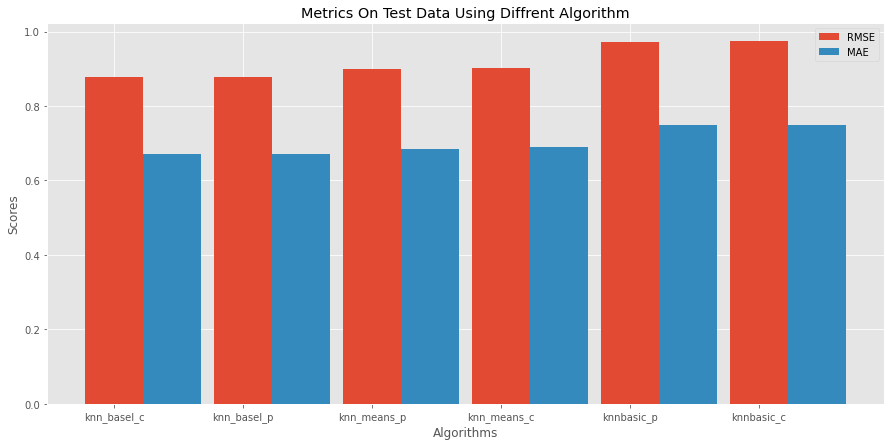

In [18]:
#Plot out the results
x_indexes = np.arange(len(algor_metrics['algorithm']))
plt.style.use("ggplot")
width=0.45

fig, ax = plt.subplots(figsize=(15,7))

ax.bar(x_indexes, algor_metrics['test_rmse'], width=width, label="RMSE")
ax.bar(x_indexes + width, algor_metrics['test_mae'], width=width, label="MAE")


ax.legend()

plt.xticks(ticks = x_indexes, labels=algor_metrics['algorithm'] )

ax.set_title("Metrics On Test Data Using Diffrent Algorithm")
ax.set_xlabel("Algorithms")
ax.set_ylabel("Scores")

# plt.tight_layout()
plt.show()

Out of all the neighbourhood based methods, the KNN baseline method using the Pearson similarity metric performed the best with a RMSE of 0.8766. Next, I will be moving onto model-based (Matrix Factorization) methods.

# Model-Based Methods (Matrix Factorization)


The Advantages that Model-Based Collaborative Filtering systems have over Memory-Based is that it scales well with larger datasets and complete input data is not required.

## SVD
The first matrix factorization method that I will use is Singular Value Decomposition. A convenient property of SVD is that it minimizes SSE which in turn means a minimize RMSE since they are monotonically related.

In [19]:
## The original parameter grid I used
# params = {'n_factors': [20, 50, 100],
#           'lr_all': [0.002, 0.005],
#           'n_epochs': [5, 10],
#          'reg_all': [0.02, 0.05, 0.1]}


# To save computational time, I will just input the best parameters that I've already found.
params = {'n_factors': [20],
          'lr_all': [0.005],
          'n_epochs': [10],
         'reg_all': [0.05]}

#Build the SVD system
g_s_svd = GridSearchCV(SVD,param_grid=params,n_jobs=-1, cv=5)
g_s_svd.fit(data)
print(g_s_svd.best_score)
print(g_s_svd.best_params)


# #Append the metrics and algorithm name to the dataframe
algor_metrics = algor_metrics.append({'algorithm': 'SVD', 'test_rmse': (g_s_svd.best_score['rmse']), 'test_mae': (g_s_svd.best_score['mae'])}, ignore_index=True)

{'rmse': 0.8779763194981067, 'mae': 0.6769587869724052}
{'rmse': {'n_factors': 20, 'lr_all': 0.005, 'n_epochs': 10, 'reg_all': 0.05}, 'mae': {'n_factors': 20, 'lr_all': 0.005, 'n_epochs': 10, 'reg_all': 0.05}}


In [20]:
algor_metrics.sort_values(by='test_rmse', axis=0, inplace=True)
algor_metrics

,algorithm,test_rmse,test_mae
0,knn_basel_c,0.877160,0.671325
6,SVD,0.877976,0.676959
1,knn_basel_p,0.878292,0.670179
2,knn_means_p,0.898395,0.684486
3,knn_means_c,0.901359,0.689674
4,knnbasic_p,0.970880,0.749804
5,knnbasic_c,0.973204,0.748952


It seems that the SVD method failed to outperform one of the nearest neighbour models. One of the reasons for this might be because we are using a smaller dataset. Matrix Factorization models scale well with larger datasets and also perform better for sparse data.

# Model Using Alternating Least Squares

Next, I will try a model that uses Alternating Least Squares for the matrix factorization. This method can prove to be more effective and robust than SVD. It allows us to set regularization measures and minimizes a loss function. It includes a bias term to avoid overfitting.

ALS is less computationally efficient than the SVD method, but is great at dealing with giant, sparse matrices.

I will be using the ALS method using Spark so I will first have to install and import the necessary libraries.

In [21]:
!apt update

Ign:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:6 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:7 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:8 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Get:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:11 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:13 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Get:14 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hit:15 http://ppa.launchpad.net/graph

In [22]:
# Install and setup pyspark. I am using this in google colab so the code might have to be change for others
!pip install pyspark


!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-3.1.2/spark-3.1.2-bin-hadoop3.2.tgz
!tar -xvf spark-3.1.2-bin-hadoop3.2.tgz
!pip install -q findspark

     |████████████████████████████████| 212.4MB 66kB/s 
     |████████████████████████████████| 204kB 51.2MB/s 
  Created wheel for pyspark: filename=pyspark-3.1.2-py2.py3-none-any.whl size=212880768 sha256=e4420dbdbe1849d9f38bb2287e0ac362932cbcc7f3169f9a213c95fb1b04982d
  Stored in directory: /root/.cache/pip/wheels/40/1b/2c/30f43be2627857ab80062bef1527c0128f7b4070b6b2d02139
Successfully built pyspark
spark-3.1.2-bin-hadoop3.2/
spark-3.1.2-bin-hadoop3.2/R/
spark-3.1.2-bin-hadoop3.2/R/lib/
spark-3.1.2-bin-hadoop3.2/R/lib/sparkr.zip
spark-3.1.2-bin-hadoop3.2/R/lib/SparkR/
spark-3.1.2-bin-hadoop3.2/R/lib/SparkR/worker/
spark-3.1.2-bin-hadoop3.2/R/lib/SparkR/worker/worker.R
spark-3.1.2-bin-hadoop3.2/R/lib/SparkR/worker/daemon.R
spark-3.1.2-bin-hadoop3.2/R/lib/SparkR/tests/
spark-3.1.2-bin-hadoop3.2/R/lib/SparkR/tests/testthat/
spark-3.1.2-bin-hadoop3.2/R/lib/SparkR/tests/testthat/test_basic.R
spark-3.1.2-bin-hadoop3.2/R/lib/SparkR/profile/
spark-3.1.2-bin-hadoop3.2/R/lib/SparkR/profile/sh

In [23]:
#Setup pyspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-1.8.0-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.2-bin-hadoop3.2"

In [24]:
# import necessary libraries
from pyspark.sql import SparkSession
from surprise.model_selection import cross_validate
from surprise.prediction_algorithms import SVD
from surprise.prediction_algorithms import KNNWithMeans, KNNBasic, KNNBaseline
from surprise.model_selection import GridSearchCV
import numpy as np
import findspark
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# instantiate SparkSession object
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [25]:
# Read the data into spark datatype
movie_ratings = spark.read.csv('ratings.csv', header='true', inferSchema='true')
# Drop the unnecessary column
movie_ratings = movie_ratings.drop('timestamp')
movie_ratings.dtypes


[('userId', 'int'), ('movieId', 'int'), ('rating', 'double')]

In [26]:
# Import necessary libraries
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS

#Split the dataset into training and testing sets
(training, test) = movie_ratings.randomSplit([0.8, 0.2], seed=1254)


# Initialize the ALS model
als_model = ALS(userCol='userId', itemCol='movieId', 
                ratingCol='rating', coldStartStrategy='drop')

## Create the parameter grid that I originally used 
# params = ParamGridBuilder() \
#             .addGrid(als_model.rank, [4, 10, 50, 100, 150]) \
#             .addGrid(als_model.regParam, [.01, .05, .1, .15]) \
#             .build()

#To save time, I will only input the parameters that I have already found to be the best
params = ParamGridBuilder()\
          .addGrid(als_model.regParam, [0.1])\
          .addGrid(als_model.rank, [4]).build()

#Build the evaluator to be used
evaluator = RegressionEvaluator(metricName='rmse', labelCol='rating',
                                predictionCol='prediction')

# Instantiate the cross-validator estimator and then fit it to training data
cv = CrossValidator(estimator=als_model, estimatorParamMaps=params,evaluator=evaluator,parallelism=4, numFolds=5)
best_model = cv.fit(training)    

print("**Best Model**")
# Print "Rank"
print("  Rank:", best_model.bestModel._java_obj.parent().getRank())
# Print "MaxIter"
print("  MaxIter:", best_model.bestModel._java_obj.parent().getMaxIter())
# Print "RegParam"
print("  RegParam:", best_model.bestModel._java_obj.parent().getRegParam())

**Best Model**
  Rank: 4
  MaxIter: 10
  RegParam: 0.1


In [27]:
# Evaluate the model by computing the RMSE on the test data
predictions = best_model.transform(test)
evaluator = RegressionEvaluator(metricName='rmse', labelCol='rating',
                                predictionCol='prediction')
evaluator_mae = RegressionEvaluator(metricName='mae', labelCol='rating',
                                predictionCol='prediction')
rmse = evaluator.evaluate(predictions)
mae = evaluator_mae.evaluate(predictions)

print('Root-mean-square error = ' + str(rmse))
print('Mean-absolute error = ' + str(mae))


#Append the metrics and algorithm name to the dataframe
algor_metrics = algor_metrics.append({'algorithm': 'ALS', 'test_rmse': (rmse), 'test_mae': (mae)}, ignore_index=True)

Root-mean-square error = 0.8784282116834234
Mean-absolute error = 0.6709810462042699


In [28]:
algor_metrics.sort_values(by='test_rmse', axis=0, inplace=True)
algor_metrics

,algorithm,test_rmse,test_mae
0,knn_basel_c,0.877160,0.671325
1,SVD,0.877976,0.676959
2,knn_basel_p,0.878292,0.670179
7,ALS,0.878428,0.670981
3,knn_means_p,0.898395,0.684486
4,knn_means_c,0.901359,0.689674
5,knnbasic_p,0.970880,0.749804
6,knnbasic_c,0.973204,0.748952


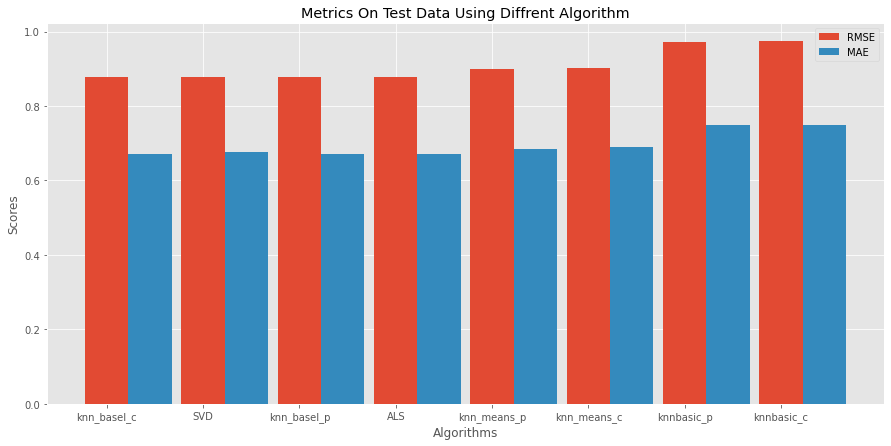

In [29]:
x_indexes = np.arange(len(algor_metrics['algorithm']))
plt.style.use("ggplot")
width=0.45

fig, ax = plt.subplots(figsize=(15,7))

ax.bar(x_indexes, algor_metrics['test_rmse'], width=width, label="RMSE")
ax.bar(x_indexes + width, algor_metrics['test_mae'], width=width, label="MAE")


ax.legend()

plt.xticks(ticks = x_indexes, labels=algor_metrics['algorithm'] )

ax.set_title("Metrics On Test Data Using Diffrent Algorithm")
ax.set_xlabel("Algorithms")
ax.set_ylabel("Scores")

# plt.tight_layout()
plt.show()

# Choosing the Final Model

The RMSE scores are so close between the KNN Baseline models and the Matrix Factorization models that the rankings change depending on the random draw of the testset.

Since I know that matrix factorization models scale better with larger datasets, I will choose the ALS method for my final model.

## New User Ratings
First I will build a function that will ask the user for new ratings so that the dataset can be better populated. This function takes in a movie dataframe containing movie ids, names, and genres. It also takes in the user id, the number of ratings you want to make, and also the genre that you like to make ratings for. This function returns a pandas dataframe.


In [30]:
# Create a function for new user ratings
def movie_rater(userID, movie_df = names_df, num=5, genre=None):
    rating_list = []
    while num > 0:
        if genre:
            movie = movie_df[movie_df['genres'].str.contains(genre)].sample(1)
        else:
            movie = movie_df.sample(1)
        print(movie)
        rating = input('How do you rate this movie on a scale of 1-5, press n if you have not seen :\n')
        if rating == 'n':
            continue
        else:
            rating_one_movie = {'userId':userID,'movieId':movie['movieId'].values[0],'rating':rating}
            rating_list.append(rating_one_movie) 
            num -= 1
    return pd.DataFrame(rating_list)

In [41]:
movie_rater(152, names_df, 3, 'Comedy')


      movieId                      title                            genres
4874     7304  Allegro non troppo (1977)  Animation|Comedy|Fantasy|Musical
How do you rate this movie on a scale of 1-5, press n if you have not seen :
n
     movieId                  title                  genres
813     1066  Shall We Dance (1937)  Comedy|Musical|Romance
How do you rate this movie on a scale of 1-5, press n if you have not seen :
3
      movieId                 title                           genres
9529   172229  Plain Clothes (1988)  Comedy|Mystery|Romance|Thriller
How do you rate this movie on a scale of 1-5, press n if you have not seen :
3
      movieId                             title                   genres
4333     6332  Lizzie McGuire Movie, The (2003)  Children|Comedy|Romance
How do you rate this movie on a scale of 1-5, press n if you have not seen :
4


,userId,movieId,rating
0,152,1066,3
1,152,172229,3
2,152,6332,4


Next I will build a function that return the movie the movie title when given a movie id. I will incoporate this function into my final function.

In [32]:
# A function that takes return the movie title when given a movie id
def name_retriever(movie_id, movie_title_df=names_df):
    return movie_title_df[names_df.movieId == movie_id]['title']


The get_value() function takes in the dataframe from movie_rater() function and change it into a form that can be read into a spark dataframe. This function will also be used in the final recommender.

In [33]:
#Function change format to prepare for spark
def get_value(df, uid= 'userId', column1='movieId', column2='rating'):
        values = df[[uid, column1, column2]].values
        return [tuple(elem) for elem in values]

# Hybrid Recommender

Now I will build a function that asks for a user id and return a pandas dataframe of movie recommendations.

The function takes in six parameters of which only the user id is required to return a dataframe containing the movie ranks, titles, genres, and predicted ratings for the user.

The function can also take in a genre to return recommendations within that category. If a genre is not specified the function will just return all categories.

The default dataset is set to the small rating dataset from MovieLens but this can change using the rating_df parameter.

New user ratings on movies can be added to the function. The new ratings will be combined with the old data and then an ALS model will be built using the combined dataset.

The default number of recommendations the function return is 5. A different number can be specified using num_recs.



In [34]:
# A final function that build the data and return recommendations.
def recommender(user_id, genre=None, new_ratings=None, rating_df = movie_ratings, movie_title_df = names_df, num_recs=5):

    # If there are no new ratings, just use the original dataset
    if isinstance(new_ratings, pd.DataFrame):
      ratings_formated = get_value(new_ratings)
      new_user_ratings = spark.createDataFrame(ratings_formated,rating_df.columns)
      new_user_ratings = new_user_ratings.withColumn("rating", new_user_ratings.rating.cast("double"))
      movie_ratings_combined = rating_df.union(new_user_ratings)
    
    else:
      movie_ratings_combined = rating_df


    # Create an ALS model and fit it to dataset above. The parameters that I used are the ones that I found above.
    als = ALS(maxIter=10,rank=4, regParam=0.1, userCol="userId", itemCol="movieId", ratingCol="rating", coldStartStrategy="drop")
    model = als.fit(movie_ratings_combined)
    
    # Create a dataframe with top 500 recommendations for all users using the recommendForAllUsers method
    recommendations = model.recommendForAllUsers(500)
    
    # Get recommendations specifically for the userId that is input into the function
    recs_for_user = recommendations.where(recommendations.userId == user_id).take(1)

    user_df = pd.DataFrame(columns = ['Ranking', 'movieId', 'Rating'])

    # Append the ranking, movies_id, and predicted rating to a dataframe, then combined with dataframe containing titles.
    # I used the name_retriver function that I created before here.
    for ranking, (movie_id, rating) in enumerate(recs_for_user[0]['recommendations']):
      movie_string = name_retriever(movie_id,movie_title_df)
      user_df = user_df.append({'Ranking': ranking+1, 'movieId': movie_id, 'Rating': rating}, ignore_index=True)
      new_user_df = pd.concat([user_df.set_index('movieId'), movie_title_df.set_index('movieId')], axis=1, join='inner')

    # Return all the top ranking movies if a genre is not specified. If a genre is specified return only movies within it.
    if genre:
      return new_user_df[new_user_df.genres.str.contains(genre, case=False)].head(num_recs)
    else:
      return new_user_df.head(num_recs)


#### Recommender Test

Now that I have build the recommender, I will test it for a random user.

First I will just ask recommendations for user 200 with no other inputs in the parameters. You can see that the function return the top 5 recommendations by default.

In [35]:
recommender(200)

,Ranking,Rating,title,genres
movieId,,,,
87234,1.0,5.731754,Submarine (2010),Comedy|Drama|Romance
26171,2.0,5.512847,Play Time (a.k.a. Playtime) (1967),Comedy
33649,3.0,5.356804,Saving Face (2004),Comedy|Drama|Romance
67618,4.0,5.296840,Strictly Sexual (2008),Comedy|Drama|Romance
184245,5.0,5.199246,De platte jungle (1978),Documentary


Next I will ask for the top 10 action movie recommendations for user 200.

In [36]:
recommender(200, genre='Action', num_recs=10)

,Ranking,Rating,title,genres
movieId,,,,
69524,26.0,5.041847,Raiders of the Lost Ark: The Adaptation (1989),Action|Adventure|Thriller
3153,33.0,4.964682,"7th Voyage of Sinbad, The (1958)",Action|Adventure|Fantasy
6300,68.0,4.795046,Flickering Lights (Blinkende lygter) (2000),Action|Comedy|Crime
82242,93.0,4.703322,Rare Exports: A Christmas Tale (Rare Exports) ...,Action|Comedy
95149,94.0,4.701075,Superman/Batman: Public Enemies (2009),Action|Animation|Fantasy
102084,95.0,4.701075,Justice League: Doom (2012),Action|Animation|Fantasy
82744,96.0,4.701075,Faster (2010),Action|Crime|Drama
108795,97.0,4.701075,Wonder Woman (2009),Action|Adventure|Animation|Fantasy
5490,105.0,4.686943,The Big Bus (1976),Action|Comedy


It seems that action movies are not that high up on the rankings for user 200. The top action movie for the user is at 43 but the predictited rating is still very high.

Next I will create new ratings for user 200 for genre "War" and add it to the recommender calculations.

In [37]:
new_ratings_df = movie_rater(200, genre="War")

      movieId                title     genres
1414     1936  Mrs. Miniver (1942)  Drama|War
How do you rate this movie on a scale of 1-5, press n if you have not seen :
n
      movieId                                        title      genres
2180     2897  And the Ship Sails On (E la nave va) (1983)  Comedy|War
How do you rate this movie on a scale of 1-5, press n if you have not seen :
4
      movieId  ...                           genres
6826    61236  ...  Animation|Documentary|Drama|War

[1 rows x 3 columns]
How do you rate this movie on a scale of 1-5, press n if you have not seen :
4
      movieId                                              title     genres
5857    32649  Special Day, A (Giornata particolare, Una) (1977)  Drama|War
How do you rate this movie on a scale of 1-5, press n if you have not seen :
n
     movieId                       title     genres
997     1299  Killing Fields, The (1984)  Drama|War
How do you rate this movie on a scale of 1-5, press n if you have no

In [38]:
new_ratings_df

,userId,movieId,rating
0,200,2897,4
1,200,61236,4
2,200,1299,4
3,200,2404,4
4,200,8795,3


In [39]:
recommender(200, genre='War', new_ratings=new_ratings_df)

,Ranking,Rating,title,genres
movieId,,,,
26073,7.0,5.205782,"Human Condition III, The (Ningen no joken III)...",Drama|War
7122,40.0,4.885101,King of Hearts (1966),Comedy|Drama|War
6818,88.0,4.719236,Come and See (Idi i smotri) (1985),Drama|War
98154,93.0,4.710220,Lincoln (2012),Drama|War
58303,102.0,4.705968,"Counterfeiters, The (Die Fälscher) (2007)",Crime|Drama|War


## Improvements

The improvements that I could make to the systems includes

- Make use of the tags datas provided to create a more in depth content based system.

- Use the larger dataset from MovieLens to build the models.

- Configure the code so that movies already rated by the user are not returned in the recommendations.